In [32]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import folium
import folium.plugins as plugins
import copy
import os
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Assignment 1.


### Import data

In [6]:
#import data from Police_Department_Incident_Reports_Historical_2003_to_May_2018.csv
data = pd.read_csv("../../../week/data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv",dtype={"Category":str,"Descript":str,"pdDistrict":str,"Resolution":str,"Address":str})

In [7]:
#Create a new column DateTime with a datetime object build from the column "Date" and "Time" - takes ~3 min
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

In [8]:
#Format the column Date into a datetime object
data['Date'] =  pd.to_datetime(data['Date'], format='%m/%d/%Y')

In [9]:
#format the column Time into a datetime.time object
data['Time'] =  pd.to_datetime(data['Time'], format='%H:%M').dt.time

## Part 1: Temporal evolution of focus crimes (From Week 2)

Police chief Suneman is interested in the temporal development of only a subset of categories, the so-called focus crimes. Those categories are listed below (for convenient copy-paste action). Create bar-charts displaying the year-by-year development of each of these categories across the years 2003-2017.

In [10]:
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

In [11]:
# Temporal development of subset of crimes:
fclist = list(focuscrimes)

# Extracts all focus crimes from dataset
condition = data.Category.isin(fclist)
df = data.loc[condition]

# We create a new dataframe which groups all entries by the columns Category and Year and shows the occurences
df2 = df.groupby(["Category", data["Date"].dt.year]).count()["IncidntNum"]
df2 = df2.unstack() # Converts from groupby object to dataframe

# We discard the values for 2018 since they are incomplete
df2.drop(df2.columns[-1], 1 , inplace = True)

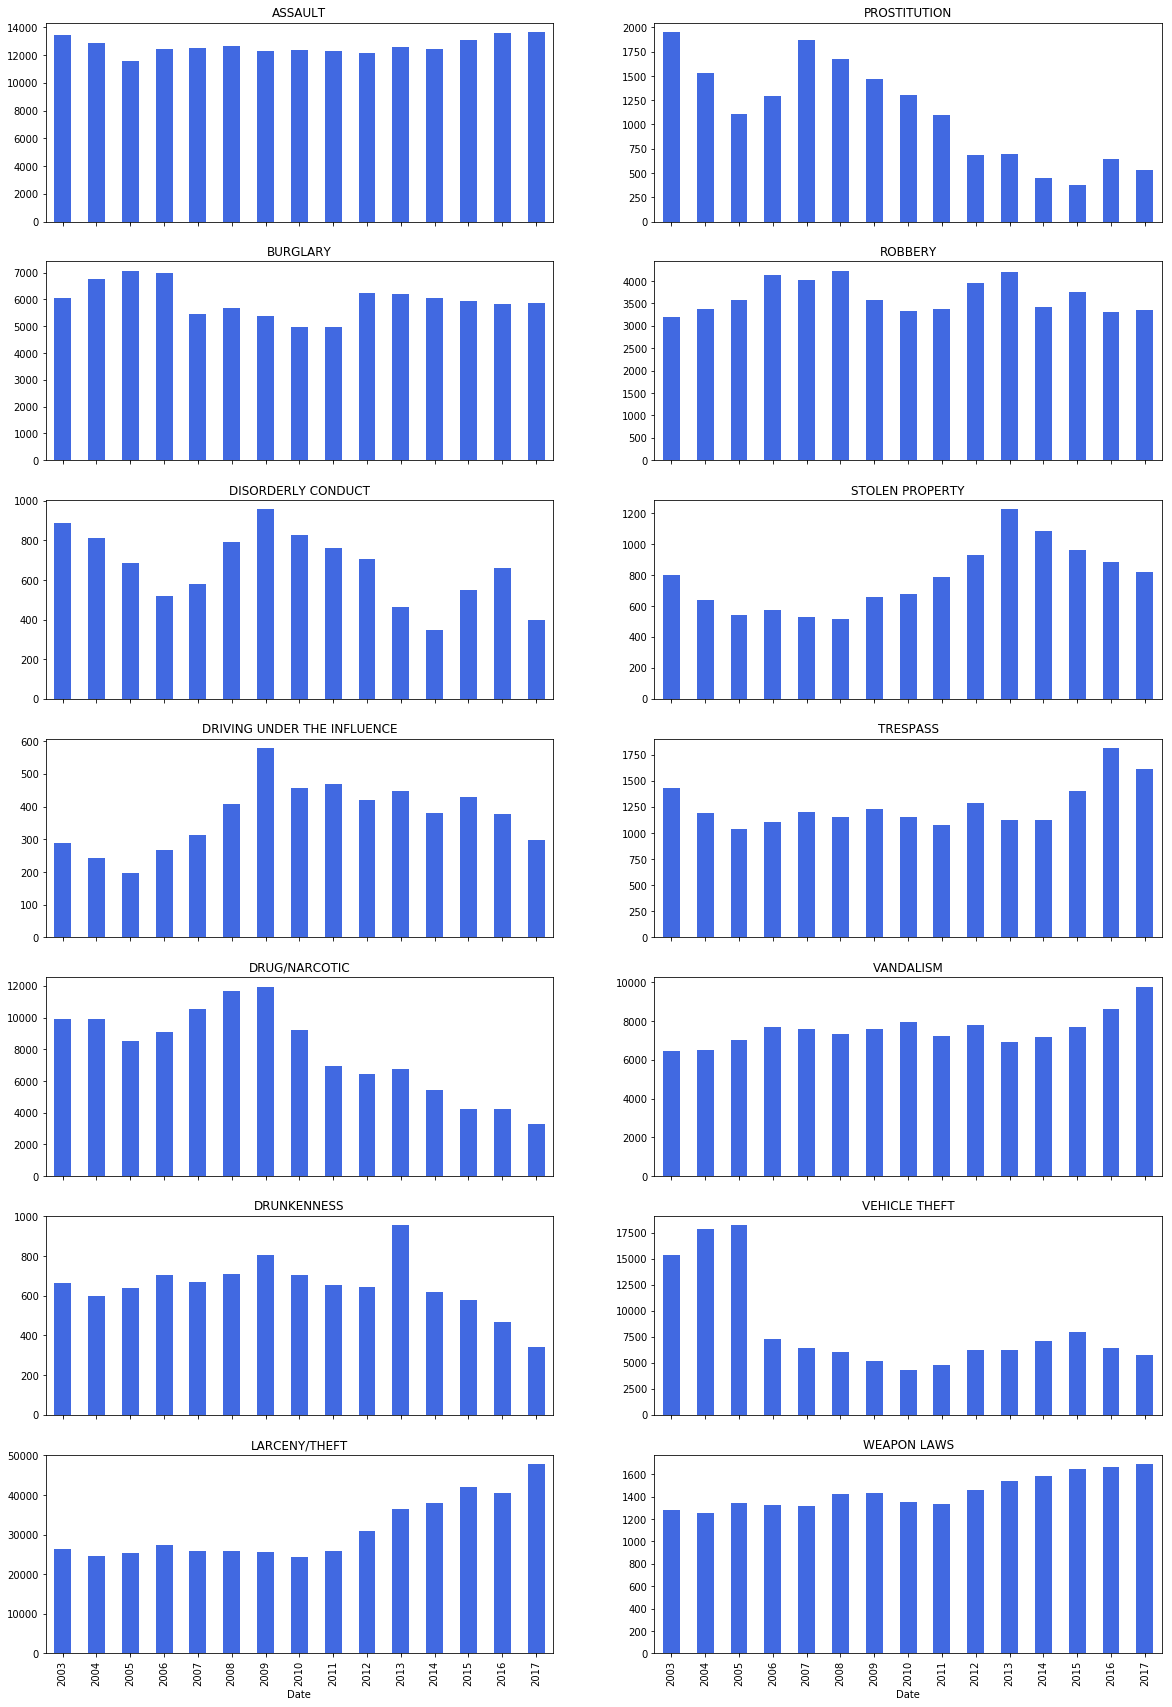

In [12]:
# Creates a figure of subplots of 7 rows, 2 columns. The x-axis are shared on columns.
fig, ax = plt.subplots(7, 2, sharex = "col", figsize = (20,30))

k = 0

# Sorts the labels in alphabetical order, just like the dataframe is
fclistsorted = copy.deepcopy(fclist)
fclistsorted.sort()

# Plots the data
for i in range(2):
    for j in range(7):
        df2.iloc[k].plot(kind = "bar", ax = ax[j, i],colors="royalblue")
        ax[j, i].set_title(fclistsorted[k])
        k += 1
        
plt.show()

**Figure 1.1** Temporal Development of the different focus crimes in San Francisco from 2003 - 2017, which gives a nice overview of the on-going trends in crime development. It can for instance be seen that Vehice Theft has decreased a lot since 2006, and that Drug/Narcotic is on a decrease.
Gesehen von Holger Krener-Iversen am 13:07


## Part 2: Visualizing geo-data (From Week 2)

*Exercise*: A bit a plotting

* Select a couple of months of data (for example, June-July 2016) for `'DRUG/NARCOTIC'` and the same couple of month for `'LARCENY/THEFT'`. **Note**: There is an issue with folium and plotting lots of points, so if you have trouble plotting simply select a shorter time period; you should be able to plot a couple of thousand points.
    * Draw a little circle for each arrest in the category `'DRUG/NARCOTIC'` for your time period. We can call this a kind of visualization a scatter plot
    * Draw a little circle for each arrest in the category `'LARCENY/THEFT'` for the time period.


In [66]:
#Select data
mask = (data['Date'] >= '2016-6-1') & (data['Date'] <= '2016-7-31') & (data['Category']=='DRUG/NARCOTIC')               
data_dn=data.loc[mask]

#take sample of the size of drug/narcotic crimes in the same period (jun-july 2016)
mask = (data['Date'] >= '2016-6-1') & (data['Date'] <= '2016-7-31') & (data['Category']=='LARCENY/THEFT')                                                         
data_lt=data.loc[mask].sample(len(data_dn))


In [68]:
#Create map and add circles to drug/narcotic
m_dn = folium.Map([37.77919, -122.41914], zoom_start=13)

for index, row in data_dn.iterrows():
    folium.CircleMarker([row['Y'], row['X']],
                        radius=5,
                        popup=row['Category'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m_dn)

#for showing the map uncomment the next line - we show a picture due to rerendering problems with folium in notebook
display(m_dn)

![maps](https://raw.githubusercontent.com/eikekutz/socialData2019/master/ass_1/maps_pic/fig2_1png.png)

**Figure 2.1** Scatter plot - showing incidents of drugs and narcotics crimes between the dates 01.06.2016 - 31.07.2016

As shown in **Figure 2.1**, a Scatter plot is an easy way to visualize the coordinates of crime occurences. The plot includes all outliers so it is easy to see how the data is distributed across the map. When there are many datapoints closely together however, it is hard to discern which area has the highest concentration of crimes. From the plot it seems like there is a higher consentration of  drug related crimes in the city center.

In [69]:
# Create new map and add circles to larceny/theft
m_lt = folium.Map([37.77919, -122.41914], zoom_start=13)

for index, row in data_lt.iterrows():
    folium.CircleMarker([row['Y'], row['X']],
                        radius=5,
                        popup=row['Category'],
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m_lt)

#for showing the map uncomment the next line - we show a picture due to rerendering problems with folium in notebook
display(m_lt)

![map1](https://raw.githubusercontent.com/eikekutz/socialData2019/master/ass_1/maps_pic/fig22.png)

**Figure 2.2** Scatter plot - showing a sample of incidents of larceny and theft crimes between the dates 01.06.2016 - 31.07.2016

As shown in **Figure 2.2** larceny and theft crimes are more prominent in the north and the city center. Because the number of larceny and theft crimes is much higher than that of drugs and narcotics, we have decided to take a sample of the incidents of the same size in the same timeframe. In this way, we can compare the geo-locations of the different crimes. The data in **Figure 2.2** is a bit more spread out and less clustered than the data in **Figure 2.1**. Nevertheless, it seems like there is a correlation between the locations of two different crime categories. 


* Now, let's play with heatmaps. 
   * Create a heatmap of all arrests for `'DRUG/NARCOTIC'` during June-July 2016 (with the heatmap you should be able to use the full period). Play with parameters to get plots you like
   * Create a heatmap of all arrests for `'LARCENY/THEFT'` during June-July 2016 (with the heatmap you should be able to use the full period).
   * Comment on the differences. What can you see using the scatter-plots that you can't see using the heatmaps? And *vice versa*: what does the heatmaps help you see that's difficult to distinguish in the scatter-plots?
   * Comment on the effect on the various parameters for the heatmaps. How do they change the picture?

In [ ]:
k = folium.Map([37.77919, -122.41914], zoom_start=13)

# convert to (n, 2) nd-array format for heatmap
stationArr = data_dn[['Y', 'X']].as_matrix()
# plot heatmap
k.add_children(plugins.HeatMap(stationArr, radius=15))

#for showing the map uncomment the next line - we show a picture due to rerendering problems with folium in notebookk
display(k)

![maps](https://raw.githubusercontent.com/eikekutz/socialData2019/master/ass_1/maps_pic/fig23.png)

**Figure 2.3** Heatmap - showing incidents of larceny and theft related crimes between the dates 01.06.2016 - 31.07.2016.

The heatmap in **Figure 2.3**, like the scatter plot in **Figure 2.1**, visualizes the coordinates of crime occurences clearly. However, the heatmap does provide a better interface for showing the concentration or density of crimes close to each other. On the other hand, outliers may appear as more more incidents than it actually is as opposed to a scatter plot. 

The heatmap of **Figure 2.3** shows us that the there are more occurences of larceny and theft crimes in the city center.  

In [ ]:
n = folium.Map([37.77919, -122.41914], zoom_start=13)

#create new dataframe with all data for the period jun-july 2016
mask = (data['Date'] >= '2016-6-1') & (data['Date'] <= '2016-7-31') & (data['Category']=='LARCENY/THEFT')                                                         
data_lt=data.loc[mask]

# convert to (n, 2) nd-array format for heatmap
stationArr = data_lt[['Y', 'X']].as_matrix()
# plot heatmap
n.add_children(plugins.HeatMap(stationArr, radius=15))
display(n)

![maps](https://raw.githubusercontent.com/eikekutz/socialData2019/master/ass_1/maps_pic/fig24.png)

**Figure 2.4** Heatmap - showing incidents of drugs and narcotics related crimes between the dates 01.06.2016 - 31.07.2016.

From looking at **Figure 2.4**, one can see that most drugs and narcoticrimes are most common in the city center and the north. Comparing larceny and theft crimes with larceny and theft, the incidents seems to be more equally distributed over the city center. Moreover, as it is possible to plot the full dataset, one can see that the number of incidents of drug related crimes is significantly higher than of larceny and theft. 

The parameter radius of the heatmap can affect how the amount of data is perceived. That is, a smaller radius gives the impression of less data and vice versa.

## Part 3: Some single variable plots (From Week 3)


*Excercise*: Connecting the dots and recreating plots from DAOST but using our own favorite dataset.

### Exercise:
* First create a jitter-plot (that is, code up something like **Figure 2-1** from DAOST from scratch), but based on SF Police data. My hunch from inspecting the file is that the police-folks might be a little bit lazy in noting down the exact time down to the second. So choose a crime-type and a suitable time interval (somewhere between a month and 6 months depending on the crime-type) and create a jitter plot of the arrest times **during a single hour** (e.g. 13-14). 

In [16]:
#Create a mask to filter for a specific time intercal and crime category
mask = (data['Date'] > '2016-6-1') & (data['Date'] <= '2016-7-31') & (data['Category']=='ROBBERY')
data_dn=data.loc[mask]
#Create index for timeintervall
index = pd.DatetimeIndex(data_dn['DateTime'])
data_s=data_dn.iloc[index.indexer_between_time('20:00', '21:00')]
print("Number of selected crimes: {0:d}".format(len(data_s)))


Number of selected crimes: 43


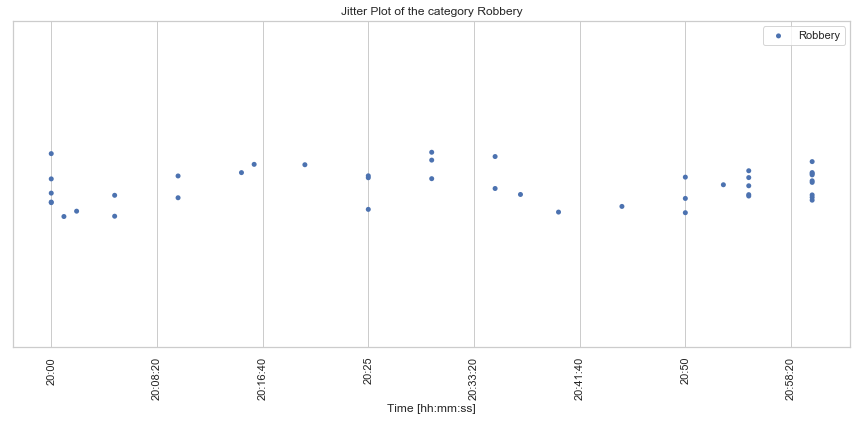

In [18]:
#Create a jitter plot using the seaborn package
f, ax = plt.subplots(figsize=(15,6))
sns.set(style="whitegrid")
data_s.sort_values(by='Time')
sns.stripplot(x=data_s['Time'],jitter=True,ax=ax,dodge=True)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90);
#change the xticks to even intervals...
ax.legend(['Robbery'])
ax.set_xlabel('Time [hh:mm:ss]')
plt.title('Jitter Plot of the category Robbery');



**Figure 3.1** Jitter plot - showing the occurence of the crime Robbery in the timeframe 20:00-21:00 between the dates 01.06.2016 - 31.07.2016<br>

As shown in **Figure 3.1**, a Jitter plot is an easy way to visualize one dimensional data. It allows you to get first insights of the data set (or a fraction of it), by showing the occurence of selected data without overlaps. In this case it shows the occurence of the crime Robbery in a specific timeframe. The max. amount of datapoints at the same time is 8 at ~21:00, which would not be visible, without the random vertical position.


### Exercise:
* Now it's time for histograms. We will now create two versions of **Figure 2-2**. 
  * Pick two crime-types with different geographical patterns **and** a suitable time-interval for each (you want between 1000 and 10000 points in your histogram)
  * Then take the latitude part of the GPS coordinates for each crime and bin the latitudes so that you have around 50 bins across the city of SF. You can use your favorite method for binning. I like `numpy.histogram` -- that gives you the counts and then you do your own plotting. *

In [21]:
#Create a mask to filter for a specific Date interval and crime category
mask = (data['Date'] > '2015-1-1') & (data['Date'] <= '2015-12-31') & (data['Category']=='ROBBERY')
data_k=data.loc[mask]
print("Number of selected crimes: {0:d}".format(len(data_k)))
data_k.head()

Number of selected crimes: 3744


,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,DateTime
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01,15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074,2015-02-01 15:45:00
14,150098367,ROBBERY,"ROBBERY, ARMED WITH A KNIFE",Sunday,2015-02-01,16:20:00,MISSION,NONE,2200 Block of MARKET ST,-122.432198,37.765111,"(37.7651107322703, -122.432198022433)",15009836703072,2015-02-01 16:20:00
20,150098414,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Sunday,2015-02-01,17:05:00,CENTRAL,"ARREST, BOOKED",PACIFIC AV / GRANT AV,-122.406832,37.796903,"(37.7969028838908, -122.406831986427)",15009841403014,2015-02-01 17:05:00
21,150098414,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01,17:05:00,CENTRAL,"ARREST, BOOKED",PACIFIC AV / GRANT AV,-122.406832,37.796903,"(37.7969028838908, -122.406831986427)",15009841403074,2015-02-01 17:05:00
25,150098420,ROBBERY,ATTEMPTED ROBBERY WITH A DEADLY WEAPON,Sunday,2015-02-01,17:10:00,TENDERLOIN,"ARREST, BOOKED",400 Block of ELLIS ST,-122.413609,37.784697,"(37.784696907904, -122.413609328985)",15009842003473,2015-02-01 17:10:00


**Table 3.1** Sample of the selected crimes of the category Robbery in the year 2015

Min. lat.:37.7083°	Max. lat.:37.8097°			Min. lng.:-122.5136°	Max. lng.:-122.3656°


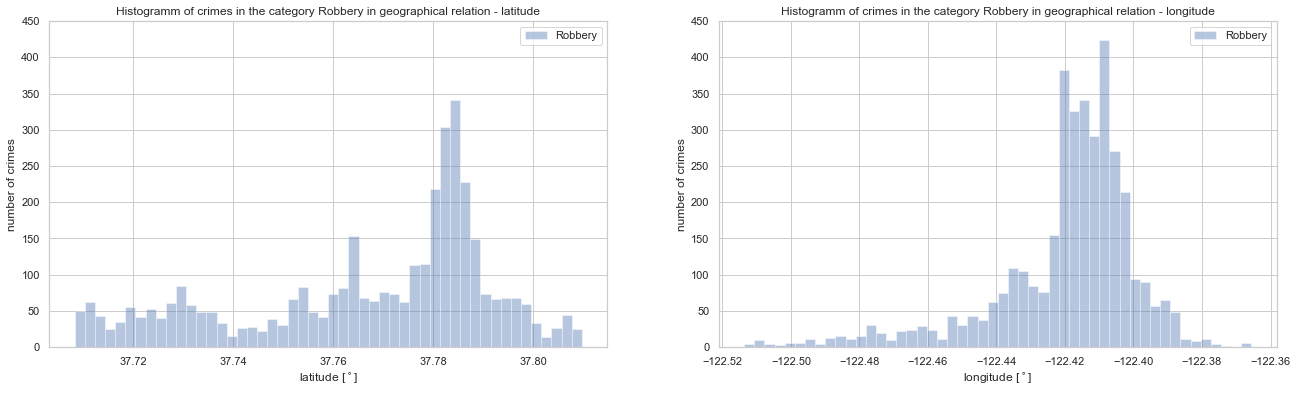

In [24]:
#Plot the histogram with 50 bins
f, ((ax1,ax2)) = plt.subplots(1,2,figsize=(22,6));
#data_k['Y'].plot.hist(bins=50, alpha=0.5,ax=ax);
sns.distplot(data_k['Y'], bins=50,ax=ax1,kde=False)

#histogram for latitude
ax1.set_xlabel('latitude [$^\circ$]');
ax1.set_ylabel('number of crimes');
ax1.legend(['Robbery'])
ax1.set_title('Histogramm of crimes in the category Robbery in geographical relation - latitude');
ax1.set_ylim([0,450])
#histogram for longitude - extra plot to get more geographical insights
sns.distplot(data_k['X'], bins=50,ax=ax2,kde=False)
ax2.set_xlabel('longitude [$^\circ$]');
ax2.set_ylabel('number of crimes');
ax2.legend(['Robbery'])
ax2.set_title('Histogramm of crimes in the category Robbery in geographical relation - longitude');
ax2.set_ylim([0,450])


print("Min. lat.:{0:4.4f}°\tMax. lat.:{1:4.4f}°\t\t\tMin. lng.:{2:4.4f}°\tMax. lng.:{3:4.4f}°".format(min(data_k['Y']),max(data_k['Y']),min(data_k['X']),max(data_k['X'])))



**Figure 3.2** Histogram showing the distribution of crimes with the category "ROBBERY" in 2015 over latitude (left) and longitude(right) presented in 50 bins (a sample of the data is shown in **Table 3.1**)<br>

In the **Figure 3.2** you can see the  that the crime "Robbery" is distributed between the latitudes of 37.7083° and 37.8097° and additionally  the longitudes between -122.5136° and -122.3656° Geographically, the most crimes happens between a lat. of 37.78° and 37.80° with a peak at ~37.785° with ~340 crimes and a lng. of -122.425° and -122.405° with a peak at ~-122.41° with 425 crimes. With this information it is possible to localize a region where crimes of the type Robbery happened  most often in 2015. 

### Exercise:

* **Next up** is recreating **Figure 2-4** from DAOST, but with the data you used to create **Figure 3.1. To create the kernel density plot, you can either use `gaussian_kde` from `scipy.stats` ([for an example, check out this stackoverflow post](https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib)) or you can use [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html).

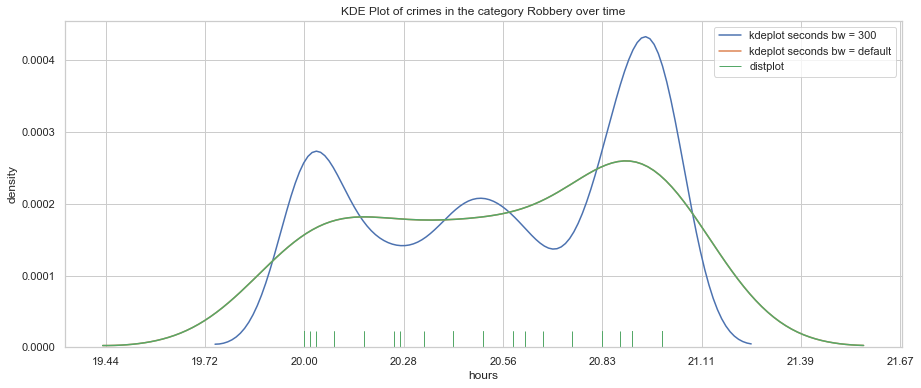

In [25]:
f, ax = plt.subplots(figsize=(15,6)) # set the size that you'd like (width, height)
data_s['seconds'] = data_s.apply(lambda row: (row.Time.hour*60+row.Time.minute)*60+row.Time.second, axis=1);

sns.kdeplot(data_s['seconds'],bw=300,ax=ax)
sns.kdeplot(data_s['seconds'],ax=ax)
sns.distplot(data_s['seconds'], hist=False, rug=True,ax=ax);
#scale x ticks from seconds to hours
x_vals = ax.get_xticks()
ax.set_xticklabels(['{:2.2f}'.format(x /3600) for x in x_vals])

ax.set_xlabel('hours');
ax.set_ylabel('density');

plt.legend(['kdeplot seconds bw = 300','kdeplot seconds bw = default','distplot']);
plt.title('KDE Plot of crimes in the category Robbery over time');

**Figure 3.3** Kernel density estimate (KDE) plot  of the crime "Robbery" in the time intervall 1.6.2016-31.7.2016 at the daytime between 20:00-21:00<br>

The KDE plot in **Figure 3.3** shows the estimated density of crimes of the type Robbery. With the default bandwith red and green(equal to green curve) two relative maxima are shown at 20.07 and 21.00. After changing the bandwith to 300 (blue curve) you can see another peak at ~20.45. A bandwith of 300 is probably a better fit for this small data set because the estimated density of the default plot makes the data a little bit to smooth.

### Exercise:

* Now grab 25 random timepoints from the dataset you've just plotted and create the same Figure 2-4 plot once again, but with fewer points. Does this shed light on why I think KDEs can bee misleading? 


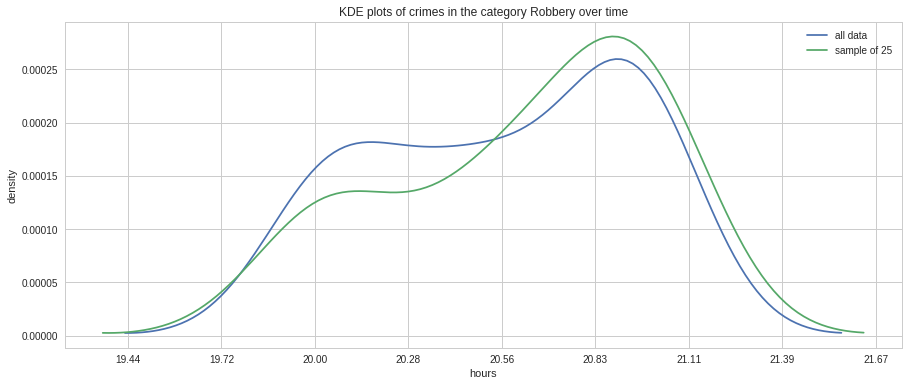

In [0]:
f, ax = plt.subplots(figsize=(15,6)) # set the size that you'd like (width, height)
sns.kdeplot(data_s['seconds'],ax=ax)
sns.kdeplot(data_s.sample(25)['seconds'],ax=ax)

#scale x ticks from seconds to hours
x_vals = ax.get_xticks()
ax.set_xticklabels(['{:2.2f}'.format(x /3600) for x in x_vals])
ax.set_title('KDE plots of crimes in the category Robbery over time')
ax.set_xlabel('hours');
ax.set_ylabel('density');
ax.legend(['all data','sample of 25']);

**Figure 3.4** Comparisson of KDE plot of the crime "Robbery" in the time intervall 1.6.2016-31.7.2016 at the daytime between 20:00-21:00 (all data) and a KDE plot of  sample of the same data with the size of 25 (sample of 25)<br>

In **Figure 3.4** you can see two KDE plots of the same data set with the exception that the green cruve is based on a sample of the size 25. You can see that the curves are relatively similar, even though the green curve is based on a sample. The plot can be missleading because the plot shows estimated values and not real values. Furthermore, the result mainly depends on the choosen bandwidth. A relative high bandwith will just show a normal distribution of the data with only one peak.

### Exercise:


* Create your own two versions of **Figure 2-11**, but using the GPS data you used for your version of Figure 2-2. Comment on the result. It is not easy to create this plot from scracth, bHint: Take a look at the `scipy.stats.probplot` function. 

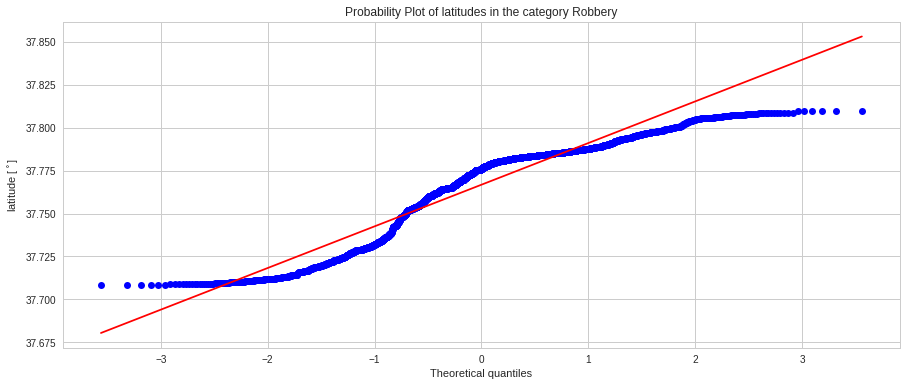

In [0]:
f, ax = plt.subplots(figsize=(15,6)) # set the size that you'd like (width, height)
stats.probplot(data_k['Y'], plot=ax);
ax.set_ylabel('latitude [$^\circ$]');
plt.title('Probability Plot of latitudes in the category Robbery');

**Figure 3.5** Probability Plot showing the distribution latitudesof crimes with the category "ROBBERY" in 2015 against the theoretical quantiles of the normal distribution<br>

As seen in **Figure 3.5** the data does not follow a normal distribution and thus the points do not fall on the red straight line.


### Exercise:


* Now box plots. Here, I'd like you to use the box plots to visualize fluctuations of how many crimes happen per day. For the 15 focus crimes defined last week.
> For the full time-span of the data, calulate the number of crimes per day within each category for the entire duration of the data (this should result in 15 datasets, on for each focus crime).
  

In [26]:
#create a list out of the focuscrimes set for easy comparisson in pandas dataframe
fc=list(focuscrimes)
#create a mask to filter for crimes that are in the list of the focuscrimes
mask =(data['Category'].isin(fc))
#Create a new dataframe for the relevant data using the mask
data_box=data.loc[mask]
#group data by Date and Category to get daily data for crimes of a certain categories
g=data_box.groupby(['Date','Category']).PdId.count()
#using the daily count to measure the average for the whole dataset
p=pd.DataFrame({'count' : data_box.groupby( ['Date','Category'] ).size()}).reset_index()

 >>Create a box-and whiskers plot showing the mean, median, quantiles, etc for each of the 15 crime-types and show them side-by-side. There are many ways to do this, I like to use [matplotlibs's built in functionality](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html)

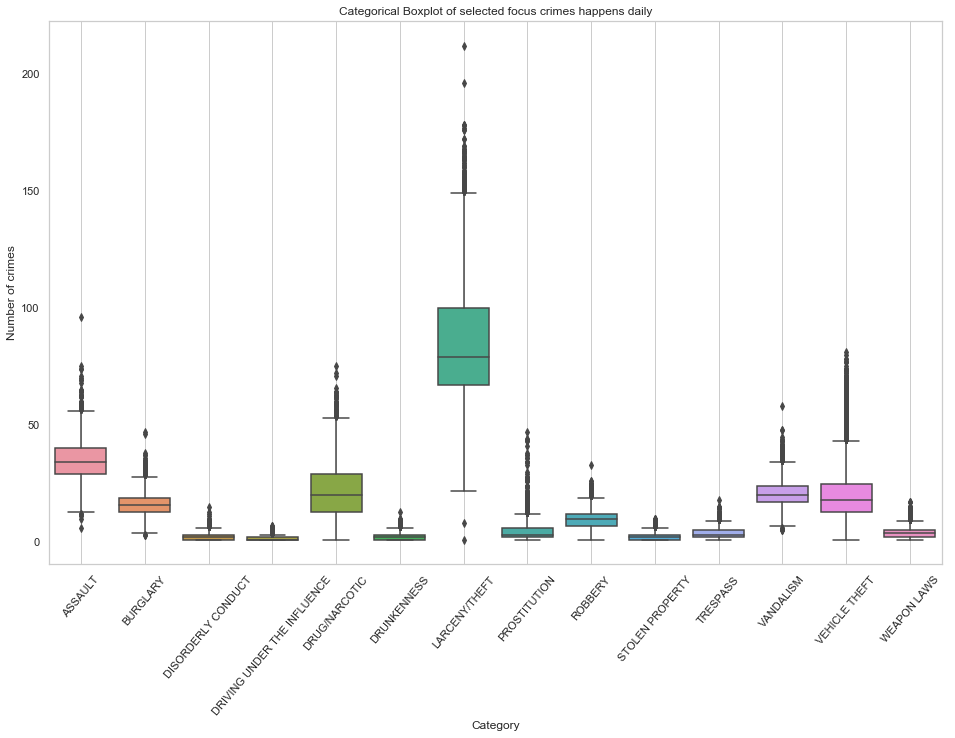

In [28]:
#plot categorical boxplot of the 15 selected crime-types
f, ax = plt.subplots(figsize=(16,10))
sns.boxplot(x="Category", y="count", data=p,ax=ax,)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50);
ax.set_ylabel('Number of crimes');
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines
plt.title('Categorical Boxplot of selected focus crimes happens daily');

**Figure 3.6** Box- and whiskers plot showing the daily crime occurence of 14 selected crimes between 2003 and May-2018<br>

  * What does this plot reveal that you can't see in the plots from last time?

The last time (week 2) we created normlized distribution for each crime of the whole dataset, which gave us insights about the relative numbers of each category. Furthermore, we ploted the distribution of crimes over years which gave us insights of annual number of crimes for each category.

Each data point in **Figure 3.6** represents the number of crimes that happened on one day over the whole dataset.
The box plot shows the quartiles (25%, median,75%) and the whiskers showing the total dimension of each crime  category. 

Instead of showing a development over time or the relative occurence of a crime, this plot reveals more insights of the daily distribution within a category (quartiles and whiskers). It is also easy to compare mutiple crimes and their daily occucences. 

## Part 4: Decision tree (From Week 4)

*Exercise*: Decision trees and real-world crime data


The idea for this exercise is to pick two crime-types that have *different geographical patterns* and *different temporal patterns*. We can then use various variables of the real crime data as categories to build a decision tree. I'm thinking we can use
* `DayOfWeek` (`Sunday`, ..., `Saturday`). (Note: Will need to be encodede as integer in `sklearn`)
* `PD District` (`TENDERLOIN`, etc). (Note: Will need to be encodede as integer in `sklearn`)

And we can extract a few more from the `Time` and `Date` variables
* Hour of the day (1-24)
* Month of the year (1-12)

So your job is to **select two crime categories** that (based on your analyses from the past three weeks) have different spatio-temporal patterns. Then we are going to to build is a decision tree (or a random forest) that takes as input the four labels (Hour-of-the-day, Day-of-the-week, Month-of-the-year, and PD-District) of some crime (from one of the two categories) and then tries to predict which category that crime is from.

Some notes/hints
* It is important for your success here to create a balanced dataset, that is, **grab an equal number of examples** from each of the two crime categories. Pick categories with lots of training data. It's probably nice to have something like 10000+ examples of each category to train on. 


* Also, I recommend you grab your training data at `random` from the set of all examples, since we want crimes to be distributed equally over time.
* A good option is the  `DecisionTreeClassifier`.
* Since you have created a balanced dataset, the baseline performance (random guess) is 50%. How good can your classifier get?

In [35]:
#Create search masks for two specific crime categories that hace different temporal patterns
mask1 =(data['Category']=='LARCENY/THEFT')
mask2 =(data['Category']=='TRESPASS')


#Create new dataframes for each crime
data_x1=data.loc[mask1].sample(n=10000)
data_x2=data.loc[mask2].sample(n=10000)

#dictionaries to cast crime and districts to integers
target = {'LARCENY/THEFT':0,'TRESPASS':1}
dist = {'MISSION':0, 'TENDERLOIN':1, 'NORTHERN':2, 'RICHMOND':3, 'BAYVIEW':4,
       'CENTRAL':5, 'PARK':6, 'TARAVAL':7, 'SOUTHERN':8, 'INGLESIDE':9, 'nan':10}

#create new coluns for casted values 
data_x1['weekday'] = data_x1.apply(lambda row: row.Date.weekday(), axis=1)
data_x1['PdDistrict_no'] = data_x1.apply(lambda row: dist[row.PdDistrict], axis=1)
data_x2['weekday'] = data_x2.apply(lambda row: row.Date.weekday(), axis=1)
data_x2['PdDistrict_no'] = data_x2.apply(lambda row: dist[row.PdDistrict], axis=1)
df_train = pd.concat([data_x1, data_x2])
df_train['dayhour'] = df_train.apply(lambda row: row.DateTime.hour, axis=1)
df_train['month'] = df_train.apply(lambda row: row.DateTime.month, axis=1)
df_train['year'] = df_train.apply(lambda row: row.DateTime.year, axis=1)

bin_no=50
geo_frac_x = abs(df_train['X'].max()-df_train['X'].min())/bin_no
geo_frac_y = abs(df_train['Y'].max()-df_train['Y'].min())/bin_no

x_dict={i:(df_train['X'].min() + geo_frac_x*i) for i in range(bin_no)}
y_dict={i:(df_train['Y'].min() + geo_frac_y*i) for i in range(bin_no)}

df_train['X_no'] = df_train.apply(lambda row:[key for key, val in x_dict.items() if float(row.X)<=val+geo_frac_x and float(row.X)>=val][0] if len([key for key, val in x_dict.items() if float(row.X)<=val+geo_frac_x and float(row.X)>=val])>0 else 999,axis=1)
df_train['Y_no'] = df_train.apply(lambda row:[key for key, val in y_dict.items() if float(row.Y)<=val+geo_frac_y and float(row.Y)>=val][0] if len([key for key, val in y_dict.items() if float(row.Y)<=val+geo_frac_y and float(row.Y)>=val])>0 else 999,axis=1)


df_train['Category_no'] = df_train.apply(lambda row: target[row.Category], axis=1)




The decision tree is based on seven different feature.
* dayhour
* weekday
* month
* year 
* district
* grouped latitude (50 bins from min to max value)
* grouped longitude (50 bins from min to max value)

Each feature gets mapped to an integer to address labels within the specific feature.
The **target**, which is in this case is the crime category, is also mapped to an integer.
After this the model gets trained with the seven different features and the target value.
We selected 10000 datapoint for each crime. In total there are 20000.
To train the model we are using 80% of the data, whereas the rest will be used to test the model.

In [ ]:
features = list(df_train.columns[-7:-1])
print("Features:", features, sep="\n")
#target values - y
y = df_train["Category_no"]
#feature values - X
X = df_train[features]
#split the data set into 80% train data and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#create and train the decision tree
dt = DecisionTreeClassifier(min_samples_split=20, random_state=42)
dt.fit(X_train, y_train)

In [31]:
#use the 20% test data so see how good the decision tree is working with our data
pre=dt.predict(X_test)
acc=sum([i == pre[idx]for idx,i in np.ndenumerate(y_test)])/len(y_test)
print("Accuracy of the model tested on 20% of the dataset: {0:4.4f}".format(acc))

Accuracy of the model tested on 20% of the dataset: 0.6152


The accuracy of the model tested on 20% of the data is 61.52%. This is only 11.52% above the baseline performance of 50%. In our point of view this accuracy is not sufficient for a good prediction.
We also tried less features ( the four recommendeded feature) and different amounts of training data, but this was the maximum we achieved.